<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/KNNClsfr_IMPrj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

W0828 12:05:20.539601 139993723807616 deprecation.py:323] From <ipython-input-2-00b17d59170f>:10: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0828 12:05:20.546740 139993723807616 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.4809653789998265
GPU (s):
0.8694385519993375
GPU speedup over CPU: 4x


In [0]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import cross_val_score

BC_data = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/Breast_Cancer_Knn_ImPrj.csv')
BC_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [0]:
BC_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sample code number,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
Clump Thickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
Uniformity of Cell Size,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
Uniformity of Cell Shape,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
Marginal Adhesion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
Single Epithelial Cell Size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
Bare Nuclei,699.0,3.537911e+00,3.650126,1.0,1.0,1.0,6.0,10.0
Bland Chromatin,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
Normal Nucleoli,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
Mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0


In [0]:
corr_matrix = BC_data.corr()
corr_matrix['Class'].sort_values(ascending=False)

Class                          1.000000
Uniformity of Cell Shape       0.818934
Uniformity of Cell Size        0.817904
Bare Nuclei                    0.817253
Bland Chromatin                0.756616
Clump Thickness                0.716001
Normal Nucleoli                0.712244
Marginal Adhesion              0.696800
Single Epithelial Cell Size    0.682785
Mitoses                        0.423170
Sample code number            -0.080226
Name: Class, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f527a3a9860>,
      dtype=object)

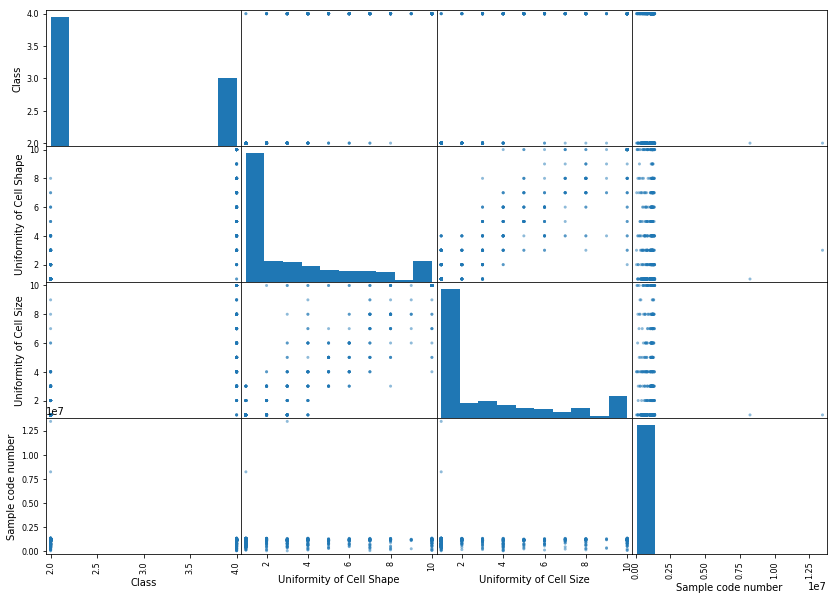

In [0]:
from pandas.plotting import scatter_matrix
attributes = ['Class', 'Uniformity of Cell Shape', 'Uniformity of Cell Size', 'Sample code number']
scatter_matrix(BC_data[attributes], figsize = (14,10))

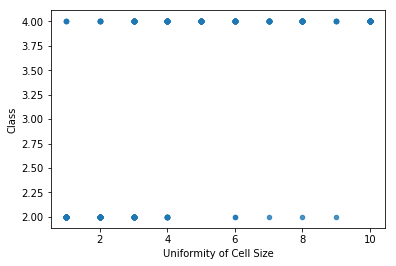

In [0]:
BC_data.plot(kind='scatter', x='Uniformity of Cell Size', y='Class', alpha=0.8)

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
BC_data_trans=imputer.fit_transform(BC_data)
BC_data_trns = pd.DataFrame(BC_data_trans, columns=BC_data.columns)

In [0]:
imputer.statistics_

array([1.07170410e+06, 4.41773963e+00, 3.13447783e+00, 3.20743920e+00,
       2.80686695e+00, 3.21602289e+00, 3.53791130e+00, 3.43776824e+00,
       2.86695279e+00, 1.58941345e+00, 2.68955651e+00])

In [0]:
corr_matrix = BC_data_trns.corr()
corr_matrix['Class'].sort_values(ascending=False)

Class                          1.000000
Uniformity of Cell Shape       0.818934
Uniformity of Cell Size        0.817904
Bare Nuclei                    0.817253
Bland Chromatin                0.756616
Clump Thickness                0.716001
Normal Nucleoli                0.712244
Marginal Adhesion              0.696800
Single Epithelial Cell Size    0.682785
Mitoses                        0.423170
Sample code number            -0.080226
Name: Class, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52207bd748>,
      dtype=object)

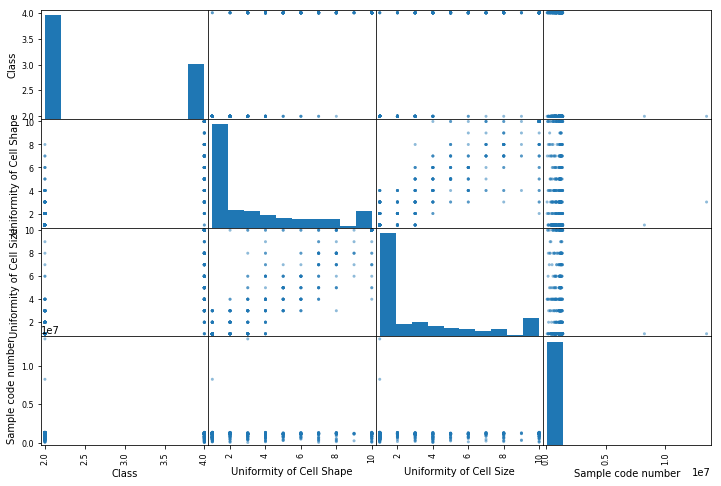

In [0]:
from pandas.plotting import scatter_matrix
attributes = ['Class', 'Uniformity of Cell Shape', 'Uniformity of Cell Size', 'Sample code number']
scatter_matrix(BC_data_trns[attributes], figsize = (12,8))

In [0]:
BC_data_trans

array([[1.000025e+06, 5.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 2.000000e+00],
       [1.002945e+06, 5.000000e+00, 4.000000e+00, ..., 2.000000e+00,
        1.000000e+00, 2.000000e+00],
       [1.015425e+06, 3.000000e+00, 1.000000e+00, ..., 1.000000e+00,
        1.000000e+00, 2.000000e+00],
       ...,
       [8.888200e+05, 5.000000e+00, 1.000000e+01, ..., 1.000000e+01,
        2.000000e+00, 4.000000e+00],
       [8.974710e+05, 4.000000e+00, 8.000000e+00, ..., 6.000000e+00,
        1.000000e+00, 4.000000e+00],
       [8.974710e+05, 4.000000e+00, 8.000000e+00, ..., 4.000000e+00,
        1.000000e+00, 4.000000e+00]])

<font color=brown size=4> 
Convert the Class values into (Malignant identifier is 4) 1 and (Benign identifier is 2) 0 to be the classifiers in this new Class. 

In [0]:
BC_data.Class[BC_data.Class == 4] = 1
BC_data.Class[BC_data.Class == 2] = 0


As we can see from the sample data, The first column (not the index) is an ID and it has no contribution to the end prediction. Hence, it can be Omitted when building the training and test datasets. 

In [0]:
X = BC_data.iloc[:, 1:10]
y = BC_data.iloc[:, 10]
#X = BC_data.iloc[:, :-1].values
#y = BC_data.iloc[:, 10].values

In [0]:
X.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [0]:
print ('X.shape -- > ', X.shape)
print ('y.shape -- > ', y.shape)

X.shape -- >  (699, 9)
y.shape -- >  (699,)


In [0]:
X.isnull().sum()
#X = X.reset_index()
#y = y.reset_index()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

In [0]:
X_train.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
82,5,2,1,1,2,1,3,1,1
51,5,3,3,4,2,4,3,4,1
220,1,1,1,2,2,1,3,1,1
559,5,1,1,1,2,1,2,1,1
544,2,1,3,2,2,1,2,1,1


In [0]:
X_test.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
158,1,1,2,1,3,1,1,1,1
499,4,1,1,1,2,1,2,1,1
396,3,1,1,1,2,1,3,1,1
155,5,5,5,6,3,10,3,1,1
321,3,1,1,1,2,1,3,1,1


In [0]:
y_train.head()

82     0
51     1
220    0
559    0
544    0
Name: Class, dtype: int64

In [0]:
y_test.head()

158    0
499    0
396    0
155    1
321    0
Name: Class, dtype: int64

<font color=brown size=4>
Normalizing data for the Algorithm to work properly. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [0]:
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 6)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())


print(k_scores)

[0.9426845522898153, 0.9211238323080428, 0.9570386192754613, 0.9570072909546594, 0.9660007974481658]


Text(0, 0.5, 'Cross-validated accuracy')

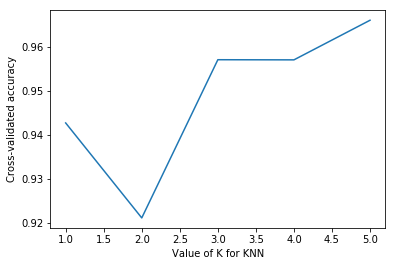

In [0]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

In [0]:
# in essence, this is basically running the k-fold cross-validation method 30 times because we want to run through K values from 1 to 30
# we should have 30 scores here
print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

Length of list 5
Max of list 0.9660007974481658


In [0]:
classifier = KNeighborsClassifier(n_neighbors=5 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))

[[94  1]
 [ 1 44]]


In [0]:
error = []

# Calculating error for K values between 1 and xxxx
for i in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

In [0]:
pred_i

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0])

Text(0, 0.5, 'Mean Error')

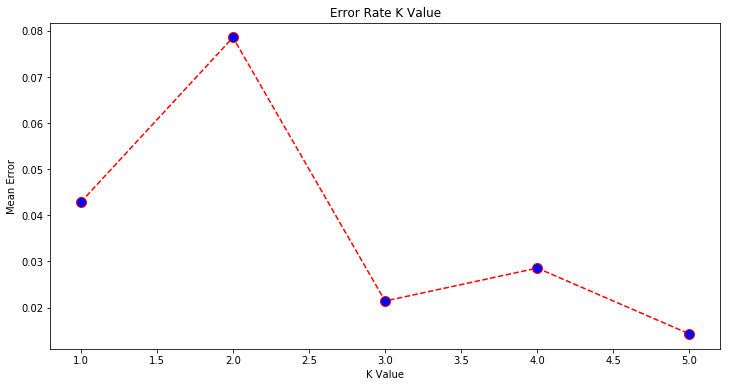

In [0]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [0]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[94  1]
 [ 1 44]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        95
           1       0.98      0.98      0.98        45

    accuracy                           0.99       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.99      0.99      0.99       140



In [0]:
print (knn.predict([[2, 10, 2, 2, 3,2,10,10, 1]]))

[1]


In [0]:
print (knn.predict([[2, 1, 2, 2, 3,2,1,1, 1]]))

[0]


In [0]:
 #10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean())

0.9600906022902043


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur